### Importing Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import os
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### Importing Dataset

In [2]:
file_path = os.path.dirname(os.path.abspath("training_validation_insertion"))
data = pd.read_csv(file_path +'\\Data_Training\\input.csv')
data.head()

,DATE,VISIBILITY,DRYBULBTEMPF,WETBULBTEMPF,DewPointTempF,RelativeHumidity,WindSpeed,WindDirection,StationPressure,SeaLevelPressure,Precip
0,2010-01-01 00:51:00,6.0,33.0,32.0,31.0,92.0,0.0,0.0,29.97,29.99,0.01
1,2010-01-01 01:51:00,6.0,33.0,33.0,32.0,96.0,0.0,0.0,29.97,29.99,0.02
2,2010-01-01 02:51:00,5.0,33.0,33.0,32.0,96.0,0.0,0.0,29.97,29.99,0.02
3,2010-01-01 03:51:00,5.0,33.0,33.0,32.0,96.0,0.0,0.0,29.95,29.97,0.02
4,2010-01-01 04:51:00,5.0,33.0,32.0,31.0,92.0,0.0,0.0,29.93,29.96,0.02


### Feature Engineering

#### Checking Data Statistics

In [3]:
data.describe()

,VISIBILITY,DRYBULBTEMPF,WETBULBTEMPF,DewPointTempF,RelativeHumidity,WindSpeed,WindDirection,StationPressure,SeaLevelPressure,Precip
count,31285.000000,31285.000000,31285.000000,31285.000000,31285.00000,31285.000000,31285.00000,31285.000000,31285.000000,31285.000000
mean,9.126696,55.499600,49.343583,42.354227,64.38079,11.235161,199.97315,29.972433,29.993479,0.005850
std,2.269435,17.249212,15.932898,19.225313,19.70002,6.191090,107.80024,0.236871,0.236632,0.040059
min,0.000000,7.000000,5.000000,-10.000000,8.00000,0.000000,0.00000,28.520000,28.540000,0.000000
25%,10.000000,42.000000,36.000000,27.000000,49.00000,7.000000,120.00000,29.830000,29.850000,0.000000
50%,10.000000,55.000000,49.000000,43.000000,65.00000,10.000000,210.00000,29.970000,29.990000,0.000000
75%,10.000000,70.000000,64.000000,59.000000,82.00000,15.000000,300.00000,30.130000,30.150000,0.000000
max,14.000000,102.000000,82.000000,78.000000,100.00000,53.000000,360.00000,30.720000,30.740000,2.410000


In [4]:
data.median()

VISIBILITY           10.00
DRYBULBTEMPF         55.00
WETBULBTEMPF         49.00
DewPointTempF        43.00
RelativeHumidity     65.00
WindSpeed            10.00
WindDirection       210.00
StationPressure      29.97
SeaLevelPressure     29.99
Precip                0.00
dtype: float64

As observed, all data fields are numeric fields with mean and median spread apart and not anywhere near to each other so we have to scale the data later.

#### Checking for missing values

In [5]:
data.isnull().sum()

DATE                0
VISIBILITY          0
DRYBULBTEMPF        0
WETBULBTEMPF        0
DewPointTempF       0
RelativeHumidity    0
WindSpeed           0
WindDirection       0
StationPressure     0
SeaLevelPressure    0
Precip              0
dtype: int64

Data does not have missing values so we don't have to perform any imputation

#### Checking for Outliers

#### Checking for Distribution

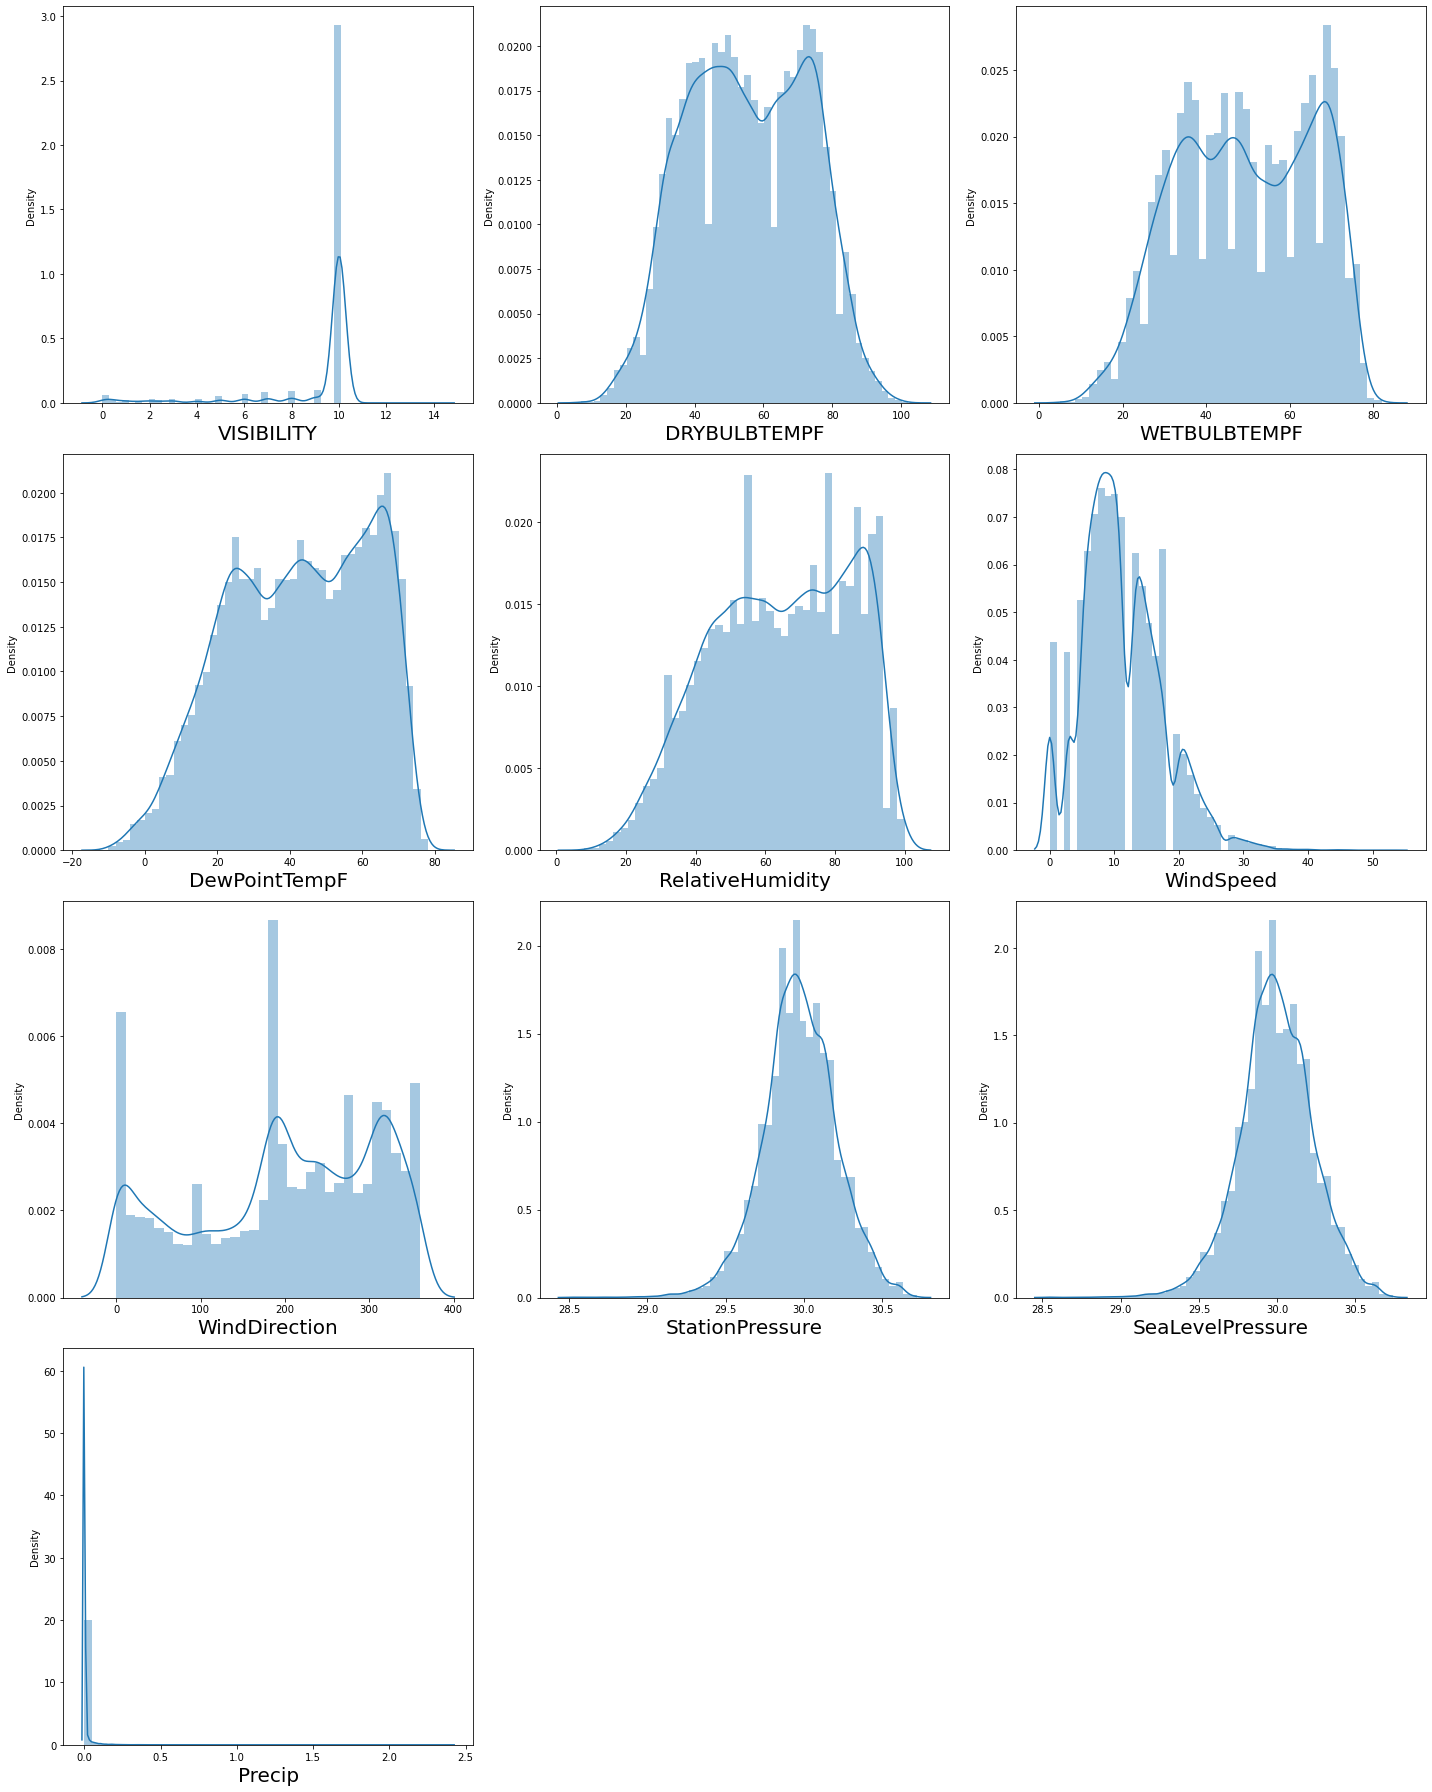

In [6]:
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in data.drop(['DATE'],axis=1):
    ax = plt.subplot(4,3,plotnumber)
    sns.distplot(data[column])
    plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.tight_layout()

Looking at the plots above, it seems like the fields StationPressure and SeaLevelPressure partly shows normal distribution and rest of the fields are not normally distributed.

### Feature Engineering

#### Separating Predictors and Response

In [7]:
X = data.drop(['VISIBILITY'],axis=1)
y = data['VISIBILITY']

In [8]:
X

,DATE,DRYBULBTEMPF,WETBULBTEMPF,DewPointTempF,RelativeHumidity,WindSpeed,WindDirection,StationPressure,SeaLevelPressure,Precip
0,2010-01-01 00:51:00,33.0,32.0,31.0,92.0,0.0,0.0,29.97,29.99,0.01
1,2010-01-01 01:51:00,33.0,33.0,32.0,96.0,0.0,0.0,29.97,29.99,0.02
2,2010-01-01 02:51:00,33.0,33.0,32.0,96.0,0.0,0.0,29.97,29.99,0.02
3,2010-01-01 03:51:00,33.0,33.0,32.0,96.0,0.0,0.0,29.95,29.97,0.02
4,2010-01-01 04:51:00,33.0,32.0,31.0,92.0,0.0,0.0,29.93,29.96,0.02
...,...,...,...,...,...,...,...,...,...,...
31280,2013-07-27 13:51:00,79.0,70.0,65.0,62.0,14.0,170.0,30.02,30.04,0.00
31281,2013-07-27 14:51:00,81.0,68.0,61.0,51.0,13.0,170.0,30.01,30.03,0.00
31282,2013-07-27 15:51:00,79.0,69.0,63.0,58.0,14.0,160.0,29.99,30.01,0.00
31283,2013-07-27 16:51:00,76.0,68.0,64.0,67.0,11.0,140.0,29.98,30.00,0.00


Since we are trying to estimate the visibility based on other parameters of weather and not based on the time of the year, we will be removing the date field.

In [9]:
X = X.drop(['DATE'],axis=1)

In [10]:
X

,DRYBULBTEMPF,WETBULBTEMPF,DewPointTempF,RelativeHumidity,WindSpeed,WindDirection,StationPressure,SeaLevelPressure,Precip
0,33.0,32.0,31.0,92.0,0.0,0.0,29.97,29.99,0.01
1,33.0,33.0,32.0,96.0,0.0,0.0,29.97,29.99,0.02
2,33.0,33.0,32.0,96.0,0.0,0.0,29.97,29.99,0.02
3,33.0,33.0,32.0,96.0,0.0,0.0,29.95,29.97,0.02
4,33.0,32.0,31.0,92.0,0.0,0.0,29.93,29.96,0.02
...,...,...,...,...,...,...,...,...,...
31280,79.0,70.0,65.0,62.0,14.0,170.0,30.02,30.04,0.00
31281,81.0,68.0,61.0,51.0,13.0,170.0,30.01,30.03,0.00
31282,79.0,69.0,63.0,58.0,14.0,160.0,29.99,30.01,0.00
31283,76.0,68.0,64.0,67.0,11.0,140.0,29.98,30.00,0.00


#### Scaling the data

In [11]:
scale = StandardScaler()
X_scaled = scale.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled

,DRYBULBTEMPF,WETBULBTEMPF,DewPointTempF,RelativeHumidity,WindSpeed,WindDirection,StationPressure,SeaLevelPressure,Precip
0,-1.304405,-1.088557,-0.590597,1.402011,-1.814760,-1.855064,-0.010273,-0.014701,0.103605
1,-1.304405,-1.025792,-0.538581,1.605060,-1.814760,-1.855064,-0.010273,-0.014701,0.353243
2,-1.304405,-1.025792,-0.538581,1.605060,-1.814760,-1.855064,-0.010273,-0.014701,0.353243
3,-1.304405,-1.025792,-0.538581,1.605060,-1.814760,-1.855064,-0.094709,-0.099222,0.353243
4,-1.304405,-1.088557,-0.590597,1.402011,-1.814760,-1.855064,-0.179145,-0.141482,0.353243
...,...,...,...,...,...,...,...,...,...
31280,1.362426,1.296484,1.177933,-0.120854,0.446591,-0.278048,0.200815,0.196601,-0.146032
31281,1.478375,1.170956,0.969871,-0.679238,0.285066,-0.278048,0.158598,0.154341,-0.146032
31282,1.362426,1.233720,1.073902,-0.323903,0.446591,-0.370814,0.074162,0.069820,-0.146032
31283,1.188502,1.170956,1.125918,0.132957,-0.037984,-0.556345,0.031944,0.027559,-0.146032


#### Checking distribution after scaling

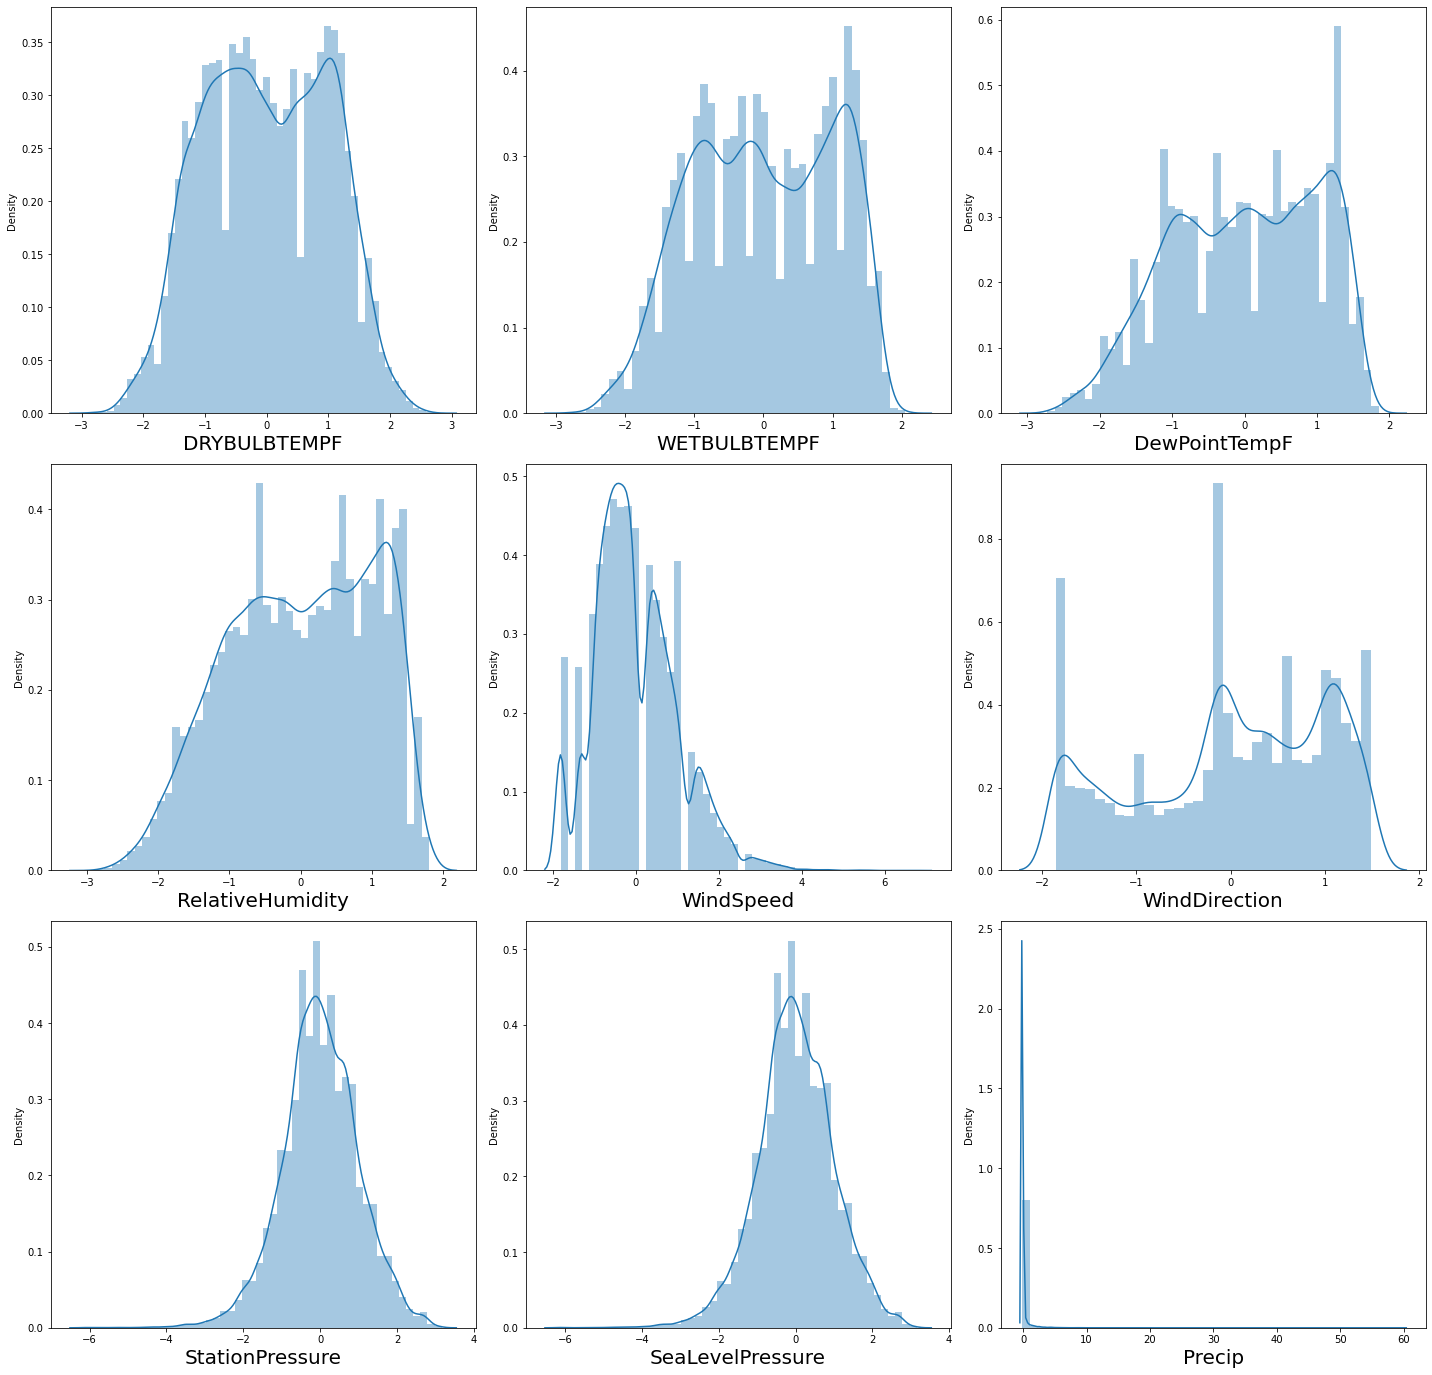

In [12]:
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in X_scaled:
    ax = plt.subplot(4,3,plotnumber)
    sns.distplot(X_scaled[column])
    plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.tight_layout()

As we observe above that most of the fields after scaling does not observe normal distribution, we will be using boosting and bagging alogrithms since they are not affected by the distribution of the predictors. Since we are using boosting and bagging alogrithms, we dont even need to scale the data.

Also when we look at the precipitation value, it is very near to zero, so it may not be a useful field, so we can drop it.

In [13]:
X = X.drop(['Precip'],axis=1)

In [14]:
X

,DRYBULBTEMPF,WETBULBTEMPF,DewPointTempF,RelativeHumidity,WindSpeed,WindDirection,StationPressure,SeaLevelPressure
0,33.0,32.0,31.0,92.0,0.0,0.0,29.97,29.99
1,33.0,33.0,32.0,96.0,0.0,0.0,29.97,29.99
2,33.0,33.0,32.0,96.0,0.0,0.0,29.97,29.99
3,33.0,33.0,32.0,96.0,0.0,0.0,29.95,29.97
4,33.0,32.0,31.0,92.0,0.0,0.0,29.93,29.96
...,...,...,...,...,...,...,...,...
31280,79.0,70.0,65.0,62.0,14.0,170.0,30.02,30.04
31281,81.0,68.0,61.0,51.0,13.0,170.0,30.01,30.03
31282,79.0,69.0,63.0,58.0,14.0,160.0,29.99,30.01
31283,76.0,68.0,64.0,67.0,11.0,140.0,29.98,30.00


#### Checking for Correlation between columns using Heatmap

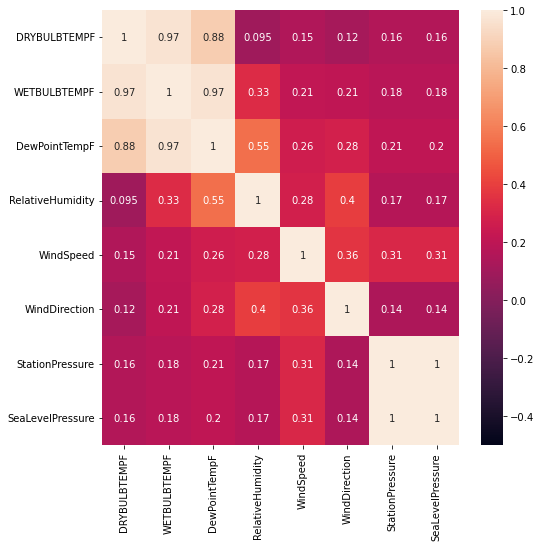

In [15]:
plt.figure(figsize=(8,8))
plt_data = X
sns.heatmap(plt_data.corr().abs(), vmin = -0.5,vmax = 1,annot=True)

Looking at the correlation chart above, we can conclude the following

1) StationPressure and SealevelPressure fields are highly correlated to each other, so we can drop StationPressure field.

2) DewPointTempF and WETBULBTEMPF fields are highly correlated to each other, so we can drop the field DewPointTempF.

3) DRYBULBTEMPF and WETBULBTEMPF fields are highly correlated to each other, so we can drop the field WETBULBTEMPF.

4) DRYBULBTEMPF and DewPointTempF fields are highly correlated to each other, but we are already dropping DewPointTempF.

In [16]:
X = X.drop(['WETBULBTEMPF','DewPointTempF','StationPressure'],axis=1)

#### Checking for Correlation after dropping features using Heatmap

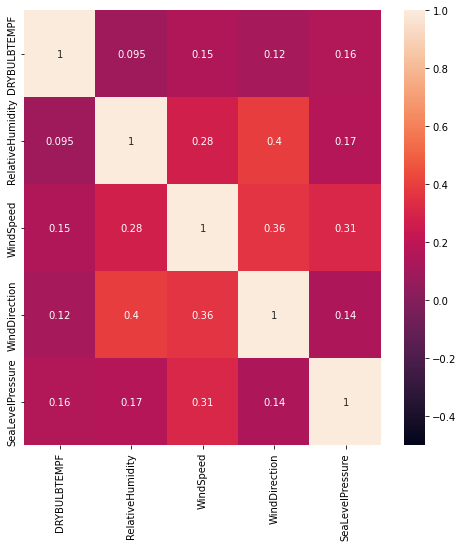

In [17]:
plt.figure(figsize=(8,8))
plt_data = X
sns.heatmap(plt_data.corr().abs(), vmin = -0.5,vmax = 1,annot=True)

The fields used are very un-correlated so they can be used in the model.

### Model Creation

In [18]:
start_time = time.time()
model_params = {
                'Linear_Regression' : {
                    'model': LinearRegression(),
                    'params':{}
                },  
                'Random_Forest': {
                    'model': RandomForestRegressor(),
                    'params' : {
                        'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 50, num = 50)],
                        'max_features' : ['auto', 'sqrt'],
                        'max_depth' : [int(x) for x in np.linspace(5, 30, num = 6)],
                        'min_samples_split' : [2, 5, 10, 15, 100],
                        'min_samples_leaf' : [1, 2, 5, 10]  
                            }
                },
                'Decision_Tree': {
                    'model': DecisionTreeRegressor(),
                    'params': {
                         "splitter"         : ["best","random"] ,
                         "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                         "min_samples_leaf" : [ 1,2,3,4,5 ],
                         "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
                         "max_features"     : ["auto","log2","sqrt",None ],
                         "max_leaf_nodes"   :[None,10,20,30,40,50,60,70]
                    }
                },
                'XG_Boost': {
                    'model': xgb.XGBRegressor(),
                    'params': { 'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 50, num = 50)],
                                'learning_rate': ['0.01','0.1', '0.2','0.3','0.5','0.6'],
                                'max_depth': [int(x) for x in np.linspace(5, 30, num = 6)],
                                'subsample': [0.7,0.6,0.8],
                                'min_child_weight': [3,4,5,6,7] }
                    }  
            }
    
scores = []
for model_name, mp in model_params.items():
    print('Running ' + model_name)
    reg =  GridSearchCV(mp['model'], param_grid = mp['params'], cv=5, scoring='r2',n_jobs=-1,verbose=3)
    reg.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': reg.best_score_,
        'best_params': reg.best_params_,
        'best_estimators' : reg.best_estimator_
    })
hyperparameter_tuning_results = pd.DataFrame(scores,columns=['model','best_score','best_params','best_estimators'])
elapsed_time = (time.time() - start_time)/60
print ('Time taken to run this code {} mins' .format(elapsed_time))

Running Linear_Regression
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Running Random_Forest
Fitting 5 folds for each of 12000 candidates, totalling 60000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 6448 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 8304 tasks      | 

Running Decision_Tree
Fitting 5 folds for each of 10240 candidates, totalling 51200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3048 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 6632 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 11240 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 16872 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 23528 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 31208 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 39912 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 49640 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 51200 out of 51200 | elapsed:   58.2s finished


Running XG_Boost
Fitting 5 folds for each of 27000 candidates, totalling 135000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1712 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2736 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3344 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4016 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 4752 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 5552 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 6416 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 7344 tasks      | 

Time taken to run this code 537.2041068514188 mins


In [19]:
hyperparameter_tuning_results

,model,best_score,best_params,best_estimators
0,Linear_Regression,0.252443,{},LinearRegression()
1,Random_Forest,0.576989,"{'max_depth': 10, 'max_features': 'sqrt', 'min...","(DecisionTreeRegressor(max_depth=10, max_featu..."
2,Decision_Tree,0.455666,"{'max_depth': 10, 'max_features': 'sqrt', 'max...","DecisionTreeRegressor(max_depth=10, max_featur..."
3,XG_Boost,0.574952,"{'learning_rate': '0.1', 'max_depth': 5, 'min_...","XGBRegressor(base_score=0.5, booster='gbtree',..."


In [21]:
hyperparameter_tuning_results.to_csv('hyperparameter_tuning_results_12142021.csv')

In [27]:
start_time = time.time()
model_params = {
                'Random_Forest': {
                    'model': RandomForestRegressor(),
                    'params' : {
                        'n_estimators': [120,150,180,200,300,400,500],
                        'max_features' : [ 'sqrt'],
                        'max_depth' : [10,100,200],
                        'min_samples_split' : [100,200,300],
                        'min_samples_leaf' : [5,15,20,25,30]  
                            }
                },
                'Decision_Tree': {
                    'model': DecisionTreeRegressor(),
                    'params': {
                         "splitter"         : ["best","random"] ,
                         "max_depth"        : [100,200,300,400,500],
                         "min_samples_leaf" : [ 5,10,15,20,25],
                         "min_weight_fraction_leaf":[0.01,0.1,1.0],
                         "max_features"     : ["auto","log2","sqrt",None ],
                         "max_leaf_nodes"   :[None,60,100,200,300,400,500]
                    }
                },
                'XG_Boost': {
                    'model': xgb.XGBRegressor(),
                    'params': { 'n_estimators': [44,60,80,100,120],
                                'learning_rate': ['0.1'],
                                'max_depth': [5],
                                'subsample': [0.6],
                                'min_child_weight': [int(x) for x in np.linspace(start = 1, stop = 100, num = 25)] }
                    }  
            }
    
scores = []
for model_name, mp in model_params.items():
    print('Running ' + model_name)
    reg =  GridSearchCV(mp['model'], param_grid = mp['params'], cv=5, scoring='r2',n_jobs=-1,verbose=3)
    reg.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': reg.best_score_,
        'best_params': reg.best_params_,
        'best_estimators' : reg.best_estimator_
    })
    print(scores)
hyperparameter_tuning_results = pd.DataFrame(scores,columns=['model','best_score','best_params','best_estimators'])
elapsed_time = (time.time() - start_time)/60
print ('Time taken to run this code {} mins' .format(elapsed_time))

Running Random_Forest
Fitting 5 folds for each of 315 candidates, totalling 1575 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1575 out of 1575 | elapsed: 11.7min finished


[{'model': 'Random_Forest', 'best_score': 0.5763979805015388, 'best_params': {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 100, 'n_estimators': 500}, 'best_estimators': RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=100, n_estimators=500)}]
Running Decision_Tree
Fitting 5 folds for each of 4200 candidates, totalling 21000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3496 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 8616 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 11944 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 15784 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 20136 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 21000 out of 21000 | elapsed:   34.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[{'model': 'Random_Forest', 'best_score': 0.5763979805015388, 'best_params': {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 100, 'n_estimators': 500}, 'best_estimators': RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=100, n_estimators=500)}, {'model': 'Decision_Tree', 'best_score': 0.5425266337327892, 'best_params': {'max_depth': 200, 'max_features': None, 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.01, 'splitter': 'random'}, 'best_estimators': DecisionTreeRegressor(max_depth=200, max_leaf_nodes=100, min_samples_leaf=5,
                      min_weight_fraction_leaf=0.01, splitter='random')}]
Running XG_Boost
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:  1.8min finished


[{'model': 'Random_Forest', 'best_score': 0.5763979805015388, 'best_params': {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 100, 'n_estimators': 500}, 'best_estimators': RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=100, n_estimators=500)}, {'model': 'Decision_Tree', 'best_score': 0.5425266337327892, 'best_params': {'max_depth': 200, 'max_features': None, 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.01, 'splitter': 'random'}, 'best_estimators': DecisionTreeRegressor(max_depth=200, max_leaf_nodes=100, min_samples_leaf=5,
                      min_weight_fraction_leaf=0.01, splitter='random')}, {'model': 'XG_Boost', 'best_score': 0.5805680120191214, 'best_params': {'learning_rate': '0.1', 'max_depth': 5, 'min_child_weight': 42, 'n_estimators': 44, 'subsample': 0.6}, 'best_estimators': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=

In [26]:
hyperparameter_tuning_results.to_csv('hyperparameter_tuning_results_12152021.csv')